# Graphical Interfaces: Plotly Dash

In [ ]:
import urllib.request
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import os

In [2]:
import datajoint as dj

schema = dj.Schema('gallery')

[2025-10-11 01:36:36,071][INFO]: DataJoint 0.14.6 connected to dev@db:3306


In [3]:
@schema
class ImageSource(dj.Lookup):
    definition = """
        image_id :  int unsigned
        ---
        image_description : varchar(60)
        url  : varchar(255)
        """
    
    contents = (
        (1, "rat cortex culture", r"https://upload.wikimedia.org/wikipedia/commons/7/75/Rat_primary_cortical_neuron_culture%2C_deconvolved_z-stack_overlay_%2830614937102%29.jpg"),
        (2, "geode", r"https://m.media-amazon.com/images/I/616UJiHwGZL.__AC_SX300_SY300_QL70_FMwebp_.jpg"),
        )

In [4]:
ImageSource()

image_id,image_description,url
1,rat cortex culture,https://upload.wikimedia.org/wikipedia/commons/7/75/Rat_primary_cortical_neuron_culture%2C_deconvolved_z-stack_overlay_%2830614937102%29.jpg
2,geode,https://m.media-amazon.com/images/I/616UJiHwGZL.__AC_SX300_SY300_QL70_FMwebp_.jpg


In [ ]:
@schema
class Image(dj.Imported):
    definition = """
    -> ImageSource
    ---
    image : longblob
    """

    def make(self, key):
        url = (ImageSource & key).fetch1('url')
        opener = urllib.request.build_opener()
        opener.addheaders = [('User-Agent', 'Mozilla/5.0')]
        urllib.request.install_opener(opener)
        urllib.request.urlretrieve(url, 'temp.jpg')
        try:
            image = PIL.Image.open("temp.jpg")
            self.insert1(dict(key, image=np.array(image)))
        finally:
            # Clean up temporary file
            if os.path.exists('temp.jpg'):
                os.remove('temp.jpg')
        


In [20]:
Image.populate(display_progress=True)

Image: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


{'success_count': 2, 'error_list': []}

In [21]:
Image * ImageSource

image_id,image,image_description,url
1,=BLOB=,rat cortex culture,https://upload.wikimedia.org/wikipedia/commons/7/75/Rat_primary_cortical_neuron_culture%2C_deconvolved_z-stack_overlay_%2830614937102%29.jpg
2,=BLOB=,geode,https://m.media-amazon.com/images/I/616UJiHwGZL.__AC_SX300_SY300_QL70_FMwebp_.jpg


(np.float64(-0.5), np.float64(269.5), np.float64(299.5), np.float64(-0.5))

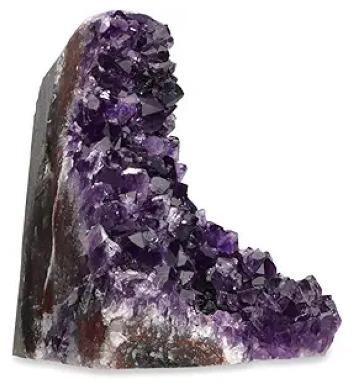

In [22]:
plt.imshow((Image & 'image_id=2').fetch1('image'))
plt.axis(False)

# GUIs and Dashboards

Several frameworks are available to build applications around database systems.
Popular frameworks for web applications in Python are Flask, Streamlit, and Plotly Dash.

We will use Plotly Dash in this course.

Cover this quick tutorial: https://dash.plotly.com/tutorial and the explore the full features of this rich framework. 

You can edit and lauch your app [directly from a jupyter notebook](https://dash.plotly.com/jupyter-notebooks/).

In [24]:
pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 25.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [25]:
# Import packages
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import pandas as pd
import plotly.express as px

# Incorporate data
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/gapminder2007.csv')

# Initialize the app
app = Dash()

# App layout
app.layout = [
    html.Div(children='My First App with Data, Graph, and Controls'),
    html.Hr(),
    dcc.RadioItems(options=['pop', 'lifeExp', 'gdpPercap'], value='lifeExp', id='controls-and-radio-item'),
    dash_table.DataTable(data=df.to_dict('records'), page_size=6),
    dcc.Graph(figure={}, id='controls-and-graph')
]

# Add controls to build the interaction
@callback(
    Output(component_id='controls-and-graph', component_property='figure'),
    Input(component_id='controls-and-radio-item', component_property='value')
)
def update_graph(col_chosen):
    fig = px.histogram(df, x='continent', y=col_chosen, histfunc='avg')
    return fig

In [27]:
# Run the app
app.run(jupyter_mode="external")



Dash app running on http://127.0.0.1:8050/


## VS Code / Cursor Port Forwarding

If you're using VS Code or Cursor with a remote connection:
- Open the Ports panel (View → Ports or Ctrl+Shift+P → "Forward a Port")
- Click "Forward a Port" and enter 8050
- Click on the forwarded URL that appears